# `1` Stock Prices

## `1.1` Linear Regression
Predicting stock prices using Linear Regression


import all the required dependencies.

In [5]:
import statsmodels.api as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nsepython import *
from datetime import date
from scipy.stats import norm

run `fetch_data.py` to fetch data
<br />
if the data is already fetched, skip this step

In [6]:
index_data = pd.read_csv('./data/index_data.csv')
new_index_data = pd.read_csv('./data/new_index_data.csv')
data_old = pd.read_csv('./data/data_old.csv')

In [7]:
index_data

,HistoricalDate,Index Name,INDEX_NAME,OPEN,HIGH,LOW,CLOSE
0,2002-01-01,Nifty Bank,Nifty Bank,NaN,NaN,NaN,870.25
1,2002-01-02,Nifty Bank,Nifty Bank,NaN,NaN,NaN,878.02
2,2002-01-03,Nifty Bank,Nifty Bank,NaN,NaN,NaN,903.03
3,2002-01-04,Nifty Bank,Nifty Bank,NaN,NaN,NaN,903.90
4,2002-01-07,Nifty Bank,Nifty Bank,NaN,NaN,NaN,886.59
...,...,...,...,...,...,...,...
3546,2016-03-23,Nifty Bank,Nifty Bank,15884.25,15919.60,15799.95,15887.00
3547,2016-03-28,Nifty Bank,Nifty Bank,15867.75,15890.70,15522.20,15604.00
3548,2016-03-29,Nifty Bank,Nifty Bank,15583.10,15774.10,15580.80,15666.00
3549,2016-03-30,Nifty Bank,Nifty Bank,15829.60,16167.50,15762.20,16134.00


In [8]:
new_index_data

,HistoricalDate,Index Name,INDEX_NAME,OPEN,HIGH,LOW,CLOSE
0,2016-04-01,Nifty Bank,Nifty Bank,16099.65,16235.80,16020.60,16174.0
1,2016-04-04,Nifty Bank,Nifty Bank,16236.90,16278.50,16046.50,16190.0
2,2016-04-05,Nifty Bank,Nifty Bank,16127.45,16147.15,15659.75,15695.0
3,2016-04-06,Nifty Bank,Nifty Bank,15750.15,15768.55,15578.55,15636.0
4,2016-04-07,Nifty Bank,Nifty Bank,15668.95,15726.60,15458.05,15530.0
...,...,...,...,...,...,...,...
243,2017-03-27,Nifty Bank,Nifty Bank,21178.10,21179.20,20979.55,21056.0
244,2017-03-28,Nifty Bank,Nifty Bank,21229.00,21264.95,21145.00,21225.0
245,2017-03-29,Nifty Bank,Nifty Bank,21291.45,21418.60,21255.75,21391.0
246,2017-03-30,Nifty Bank,Nifty Bank,21374.35,21696.00,21331.90,21620.0


In [9]:
data_old

,_id,CH_SYMBOL,CH_SERIES,CH_MARKET_TYPE,CH_TRADE_HIGH_PRICE,CH_TRADE_LOW_PRICE,CH_OPENING_PRICE,CH_CLOSING_PRICE,CH_LAST_TRADED_PRICE,CH_PREVIOUS_CLS_PRICE,...,CH_ISIN,CH_TIMESTAMP,TIMESTAMP,createdAt,updatedAt,__v,SLBMH_TOT_VAL,VWAP,mTIMESTAMP,CA
0,641f31b44708d50007274d25,HDFCBANK,EQ,N,230.00,222.75,228.00,225.05,226.00,225.60,...,NaN,2002-01-01,2001-12-31T18:30:00.000Z,2023-03-25T17:39:00.692Z,2023-03-25T17:39:00.692Z,0,NaN,225.02,01-Jan-2002,NaN
1,641f32744438f60007b7ce4d,HDFCBANK,EQ,N,225.75,223.00,224.00,225.00,225.00,225.05,...,NaN,2002-01-02,2002-01-01T18:30:00.000Z,2023-03-25T17:42:12.909Z,2023-03-25T17:42:12.909Z,0,NaN,224.53,02-Jan-2002,NaN
2,641f3270adde0b0007d23e28,HDFCBANK,EQ,N,227.95,222.20,225.00,226.25,227.75,225.00,...,NaN,2002-01-03,2002-01-02T18:30:00.000Z,2023-03-25T17:42:08.208Z,2023-03-25T17:42:08.208Z,0,NaN,224.70,03-Jan-2002,NaN
3,641f326a341dfa0007d37446,HDFCBANK,EQ,N,228.00,223.50,225.00,223.95,223.75,226.25,...,NaN,2002-01-04,2002-01-03T18:30:00.000Z,2023-03-25T17:42:02.801Z,2023-03-25T17:42:02.801Z,0,NaN,224.49,04-Jan-2002,NaN
4,641f31364708d500072748bd,HDFCBANK,EQ,N,226.35,221.55,224.00,223.95,224.15,223.95,...,NaN,2002-01-07,2002-01-06T18:30:00.000Z,2023-03-25T17:36:54.390Z,2023-03-25T17:36:54.390Z,0,NaN,223.79,07-Jan-2002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3631,641ebc1f4438f60007b5a3a4,HDFCBANK,EQ,N,1053.00,1041.65,1045.00,1047.50,1052.30,1049.35,...,INE040A01026,2016-03-28,2016-03-27T18:30:00.000Z,2023-03-25T09:17:19.098Z,2023-03-25T09:17:19.098Z,0,NaN,1048.62,28-Mar-2016,NaN
3632,641ebc1f4438f60007b5a3a4,HDFCBANK,EQ,N,1053.00,1041.65,1045.00,1047.50,1052.30,1049.35,...,INE040A01026,2016-03-28,2016-03-27T18:30:00.000Z,2023-03-25T09:17:19.098Z,2023-03-25T09:17:19.098Z,0,NaN,1048.62,28-Mar-2016,NaN
3633,641ebc2931da23000791a595,HDFCBANK,EQ,N,1059.50,1044.25,1047.50,1053.80,1053.00,1047.50,...,INE040A01026,2016-03-29,2016-03-28T18:30:00.000Z,2023-03-25T09:17:29.178Z,2023-03-25T09:17:29.178Z,0,NaN,1054.95,29-Mar-2016,NaN
3634,641ebc33a077ee000756e4ac,HDFCBANK,EQ,N,1069.90,1053.90,1058.00,1064.95,1066.30,1053.80,...,INE040A01026,2016-03-30,2016-03-29T18:30:00.000Z,2023-03-25T09:17:39.302Z,2023-03-25T09:17:39.302Z,0,NaN,1063.19,30-Mar-2016,NaN


calculate returns of index and asset data as percentage change

In [10]:
index_data['Returns'] = index_data['CLOSE'].pct_change()
index_data_returns = index_data.Returns[1:]

new_index_data['Returns'] = new_index_data['CLOSE'].pct_change()
new_index_data_returns = new_index_data.Returns[1:]

data_old['Returns'] = data_old['CH_CLOSING_PRICE'].pct_change()
asset_data_returns = data_old.Returns[1:]

Take last 10 values of the asset and index data to calculate stock price

In [11]:
asset_data_returns = asset_data_returns[-10:]
index_data_returns = index_data_returns[-10:]
asset_data_returns = np.array(asset_data_returns)
index_data_returns = np.array(index_data_returns)

Fit Ordinary Least Square Model to find alpha and beta values for the linear regression

In [12]:
def ordinary_least_square_model(asset_returns, index_returns):
    asset_returns = stats.add_constant(asset_returns)
    model = stats.OLS(index_returns, asset_returns).fit()
    asset_returns = asset_returns[:, 1]
    return model

In [13]:
model = ordinary_least_square_model(asset_data_returns, index_data_returns)
model


In [14]:
alpha = model.params[0]
beta = model.params[1]

In [15]:
print("Alpha is: ", alpha)
print("Beta is: ", beta)

Alpha is:  0.002832098259517888
Beta is:  0.6231877891948565


Plot the linear regression

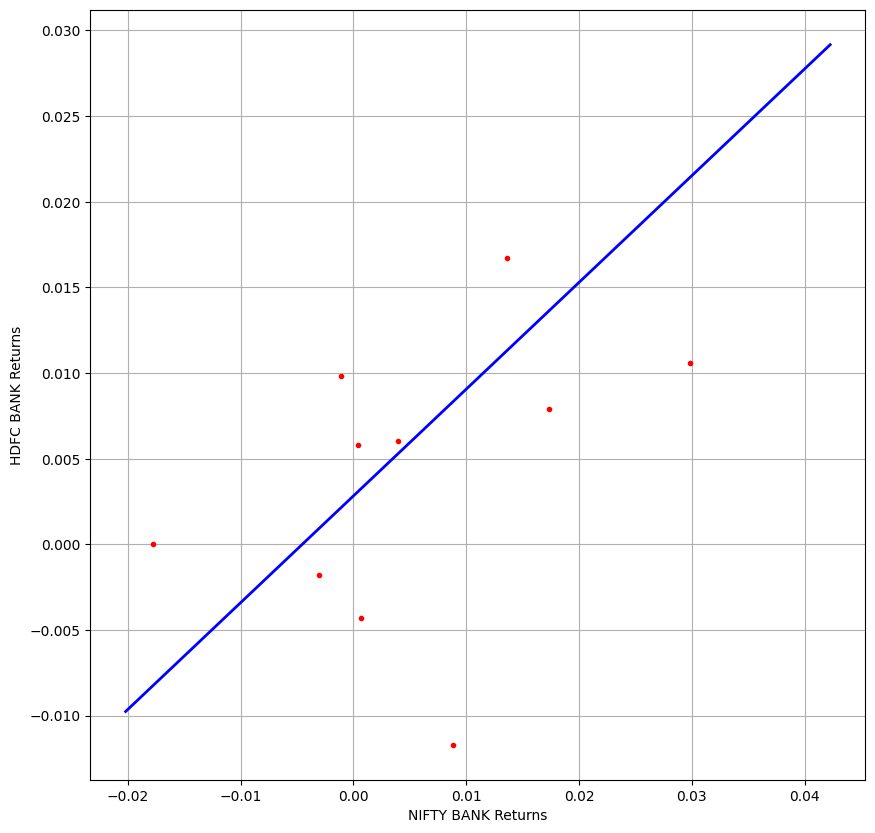

In [16]:
fig = plt.figure(figsize=(10, 10))
plt.plot(index_data_returns, asset_data_returns, 'r.')
ax = plt.axis()
x = np.linspace(ax[0], ax[1] + 0.01)
plt.plot(x, alpha + beta * x, 'b', lw=2)

plt.grid(True)
plt.axis('tight')
plt.xlabel('NIFTY BANK Returns')
plt.ylabel('HDFC BANK Returns')
plt.show()

Calculate the asset returns by using the obtained values of alpha and beta

In [17]:
predicted_asset_returns = alpha + beta * new_index_data_returns

In [18]:
predicted_asset_returns = 1 + predicted_asset_returns
predicted_asset_returns

1      1.003449
2      0.983778
3      1.000489
4      0.998607
5      1.004357
         ...   
243    1.000885
244    1.007834
245    1.007706
246    1.009504
247    0.997759
Name: Returns, Length: 247, dtype: float64

The calculated asset prices are as follows:

In [19]:
predicted_asset_price = data_old['CH_CLOSING_PRICE'].iloc[-1] * predicted_asset_returns.cumprod()
predicted_asset_price[0:10]

1     1074.843948
2     1057.408354
3     1057.925888
4     1056.452585
5     1061.055509
6     1074.679048
7     1080.347696
8     1100.281231
9     1101.038435
10    1109.528495
Name: Returns, dtype: float64

To check the fit of the linear regression model, we find the r-squared value

In [20]:
# data_old['CH_CLOSING_PRICE'].iloc[-1]
model.rsquared

0.15944128387997902

`r-square` value shows that linear model does not fit well to past 10 days data.
<br>
Thus we move to the stochastic model derived using `Brownian Motion` using stochastic calculus. 

## `1.2` Stochastic Model
`Brownian Motion` Just as deterministic curves can be considered as comprising of infinitesimal increments of straight lines, stochastic trajectories may be assumed to be formed by infinitesimal increments of `Brownian motion`.
<br />
![images/brownian.png](images/brownian.png)

Modeling the stock prices as a `Wiener Process`
<br />
![images/stochastic_on_brownian.png](images/stochastic_on_brownian.png)

Set `inflation rate` and `bond yield` to calculate `risk free rate` of return for our model
<br/>
![./images/rfr.png](./images/rfr.png)
<br/>
Taking nominal risk free rate as the 10 year bond yield

In [21]:
# Inflation rate is 3.85% as of 2023 April
inflation_rate = 0.0385

# 10 year bond yield is 7.229% as of 2023 April
bond_yield = 0.07229

# Risk free rate calculation
risk_free_rate = ((1 + bond_yield) /  (1 + inflation_rate)) - 1

print("Risk free rate is: ", risk_free_rate)

Risk free rate is:  0.032537313432835724


As the required data is already fetced, read the csv files(`data_old` and `data_new`) from `data` folder and store the data in respective dataframes
<br />

In [22]:

data_old = pd.read_csv('./data/data_old.csv')
data_new = pd.read_csv('./data/data_new.csv')

Add new colunm `log_returns` to the dataframe to store log returns
<br />
`Volatility` is calculated as the standard deviation of log returns
<br />
`Annualized Volatility` is calculated by multiplying the Volatility by the square root of `252` (number of trading days in a year)
<br />
![./images/daily_returns.png](./images/volatility.png)
<br />
`spot_price` is the closing price of the stock on the last trading day of the year

In [70]:
data_old['log_returns'] = np.log(data_old['CH_CLOSING_PRICE'] / data_old['CH_CLOSING_PRICE'].shift(1))
# export to csv
data_old.to_csv(r'./data/data_old_log_returns.csv', index=False)

d_std = data_old['log_returns'].std()
annualized_volatility = d_std * 252 ** 0.5

# Spot price
spot_price = data_old['CH_CLOSING_PRICE'].iloc[-1]

Generating m different values for the stock price on maturity(T) 
<br />
considering the stock follows `brownian motion with drift`

In [71]:

def generate_prices(spot_price, risk_free_rate, annualized_volatility, T,m):
    prices = spot_price * np.exp((risk_free_rate - 0.5 * annualized_volatility ** 2) * T + annualized_volatility * np.sqrt(T) * np.random.normal(0, 1, m))
    return prices

m=100000
# time to maturity is taken as 30 days
T=30.0/252.0
prices = generate_prices(spot_price, risk_free_rate, annualized_volatility,T,m)
print(spot_price)
print(prices)

1071.15
[ 901.83895516 1111.11149984  914.96960896 ...  802.19428433 1327.43316761
  966.99035406]


# `2` European Options
A call option gives the holder the right to buy the underlying asset at an agreed strike price.
<br/>
A put option gives the holder the right to sell the underlying asset at an agreed strike price.
<br/>
A European option is the type of options contract that allows investors to exercise their options only on the expiration date of that contract.

## `2.1` Monte Carlo Simulation
Set the `strike price`: the price at which the option can be exercised
<br />
`payoff_generation` function calculates both `call` and `put` options' payoffs
<br />
<br />
`call payoff = max(0, spot_price - strike_price)`
<br />
`put payoff = max(0, strike_price - spot_price)`
<br />
<br />
![./images/mcs.png](./images/mcs.png)

Expected payoff is calculated using Monte Carlo Simulation

In [72]:
strike_price = 1070.00
# Calculating Payoffs
def payoff_generation(strike_price, simulation_count = 10000):
    call_payoffs = np.zeros(simulation_count)
    put_payoffs = np.zeros(simulation_count)
    prices = generate_prices(spot_price, risk_free_rate, annualized_volatility, T,simulation_count)
    call_payoffs = np.maximum(prices - strike_price, 0)
    put_payoffs = np.maximum(strike_price - prices, 0)
    return call_payoffs, put_payoffs

Declare function to calculate `call` and `put` options' pricing using respective payoffs

In [73]:
# Calculating the call and put option prices
def option_price_calculation(strike_price, simulation_count = 100000):
    call_payoffs, put_payoffs = payoff_generation(strike_price, simulation_count)
    call_price = np.mean(call_payoffs) * np.exp(-risk_free_rate * T)
    put_price = np.mean(put_payoffs) * np.exp(-risk_free_rate * T)
    return call_payoffs, put_payoffs, call_price, put_price

Call above declared function to calculate `call` and `put` pricing

In [74]:
# Executing the function
call_payoffs, put_payoffs, call_price, put_price = option_price_calculation(strike_price)
# print(call_payoffs)

In [75]:
# Printing the results
print("Call Option price is: ", call_price)
print("Put Option price is: ", put_price)

Call Option price is:  79.80109097938443
Put Option price is:  75.10825996657017


Checking if the prices obtained satisfy put call parity condition to make sure there is no arbitrage in the prices
<!-- <br/> -->


![./images/parity.jpg](./images/parity.jpg)

In [76]:
# Calculating Put Call Parity
def put_call_parity_calculation(call_price, put_price, spot_price, strike_price, risk_free_rate, T):
    lhs = call_price - put_price
    rhs = spot_price - strike_price * np.exp(-risk_free_rate * T)
    return lhs-rhs

# Executing the function
put_call_parity_calculation(call_price, put_price, spot_price, strike_price, risk_free_rate, T)

-0.5937862159529743

## `2.2` Black Scholes Model

Deriving `Black Scholes Model` using Ito's calculus.
<br/>
![./images/bsm.png](./images/bsm.png)

Deriving `Black Scholes PDE`.
<br/>
![./images/black_scholes_pde.png](./images/black_scholes_pde.png)

Boundary Conditions:
<br/>
![./images/boundary_conditions.png](./images/boundary_conditions.png)

BS solutions for Calls & Puts:
<br/>
![./images/bs_solution.png](./images/bs_solution.png)

Calculate d1 and d2

In [66]:
# Now lets calculate the option price using Black Scholes formula
# First we need to calculate the d1 and d2 values

# Calculating d1
def d1_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d1 = (np.log(spot_price/strike_price) + (risk_free_rate + 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
    return d1

# Calculating d2
def d2_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d2 = (np.log(spot_price/strike_price) + (risk_free_rate - 0.5 * annualized_volatility**2) * T) / (annualized_volatility * np.sqrt(T))
    return d2

Calculate Call and Put option price

In [67]:
# Calculating the call and put option prices using Black Scholes formula
def option_price_calculation_black_scholes(spot_price, strike_price, risk_free_rate, annualized_volatility, T):
    d1 = d1_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
    d2 = d2_calculation(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
    call_price = spot_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * T) * norm.cdf(d2)
    put_price = strike_price * np.exp(-risk_free_rate * T) * norm.cdf(-d2) - spot_price * norm.cdf(-d1)
    return call_price, put_price

In [68]:
# Executing the function
call_price_black_scholes, put_price_black_scholes = option_price_calculation_black_scholes(spot_price, strike_price, risk_free_rate, annualized_volatility, T)
print("Call Option price using Black Scholes formula is: ", call_price_black_scholes)
print("Put Option price using Black Scholes formula is: ", put_price_black_scholes)

Call Option price using Black Scholes formula is:  80.29148755106883
Put Option price using Black Scholes formula is:  75.00487032230183


The results obtained through Monte Carlo simulation have been found to be comparable to those obtained using the Black-Scholes model, thereby validating the accuracy of the Monte Carlo simulation.

## References

1. Zerodha Varsity https://zerodha.com/varsity/
2. NPTEL IIT Roorkee Prof. JP Singh - Financial Derivatives and Risk Management - https://www.youtube.com/playlist?list=PLLy_2iUCG87CTB2vv9njHaJbmQoa9S5gK
3. Investopedia Options - https://www.investopedia.com/terms/o/option.asp